# **Food Commodity Prices Analysis and Forecasting in Kenya**

**By:** Charles Kagwanja   **|**   Kevin Kagia  |   Lucy Njambi  |
 Mwenda Mugambi



---


# 1. **Project Overview**

## 1.1 Objective
This project aims to analyze and predict wholesale prices in Nairobi, Kenya, harnessing historical data to develop predictive models. It focuses on identifying trends and factors influencing these prices, thereby facilitating informed decision-making in agricultural planning, budgeting, and policy formulation. The project's overarching goal is to contribute to poverty alleviation, improved nutrition, and the realization of the UN Sustainable Development Goal of zero hunger in Kenya.

## 1.2 Business Context
Focused on Nairobi County's volatile food market, this project addresses the challenge of price unpredictability that affects various sectors. By leveraging data analytics and Time series modeling, the goal is to enhance decision-making processes for entities involved in the supply chain, aligning with efforts to combat poverty and ensure food security in Kenya.

## 1.3 Business Challenge
The main challenge is developing a reliable forecasting model capable of accurately predicting prices, crucial for effective planning and strategizing. This involves analyzing complex market dynamics and data patterns to anticipate future trends.

**Stakeholders**
* **Nairobi County Government:** Plays a pivotal role in local governance, including agricultural market oversight and support within Nairobi. 
* **Kenyan Ministry of Agriculture:** Responsible for agricultural policies and market regulation.
* **Retailers and Distributors:** Key players in the supply chain, managing distribution and sales of beans.

## 1.4 Why This Project Matters
1. **Consumer Protection and Budgeting**: Assisting consumers, especially in lower-income groups, to better plan their food budgets.

2. **Policy Making and Food Security**: Enabling policymakers to formulate strategies that can stabilize food markets and ensure food security.

3. **Retail and Distribution Management**: Helping retailers and distributors in optimizing their inventory and pricing strategies.

4. **Research and Development**: Contributing to academic and practical research in market dynamics and agricultural economics.

# 2. **Data Understanding**
### 2.1 Data Source

The dataset for this project was obtained from the Humanitarian Data Exchange (HDX), specifically from the World Food Programme's food price database for Kenya. The dataset can be accessed [here](https://data.humdata.org/dataset/wfp-food-prices-for-kenya).

This dataset is particularly suitable for our analysis due to the following reasons:
1. **Comprehensiveness**: It covers a wide range of food commodities and spans multiple regions within Kenya.
2. **Relevance**: The data directly relates to the prices of food commodities, which is the central focus of our project.
3. **Timeliness**: The dataset includes recent data, which is crucial for accurate forecasting.

First, we'll load the dataset and take a preliminary look at its structure, types of data it contains, and any initial observations we can make about it.

In [2]:
# Importing necessary Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# !pip install pystan
# !pip install prophet --no-binary :all:
# from prophet import Prophet
import itertools

!pip install pmdarima
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### 2.2 Dataset Overview
Here, we will load the dataset and present its size, and an overview of its features.

In [3]:
# Loading the dataset
data = pd.read_csv('Data/wfp_food_prices_ken.csv')

# Checking the size of the dataset
print(f"\nThe dataset contains {data.shape[0]} rows and {data.shape[1]} columns.\n")


The dataset contains 15736 rows and 14 columns.



In [4]:
# Checking the columns in our dataframe
data.columns

Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency',
       'price', 'usdprice'],
      dtype='object')

#### **Column Descriptions**
- <code><b>(date):</b></code>, Indicates the date of the price recording
- <code><b>Administrative Levels (admin1, admin2):</b></code>, Geographical categorizations, Representing different regions and sub-regions in Kenya.
- <code><b>(market):</b></code>,  The specific market where prices were recorded.
- <code><b>(latitude, longitude): </b></code>,  The geographical location of each market.
- <code><b> (category): </b></code>, The type of food commodity (e.g., cereals, pulses).
- <code><b> (commodity): </b></code>, The specific food item (e.g., Maize, Beans).
- <code><b> (unit): </b></code>,The unit of measurement for the price.
- <code><b> (priceflag): </b></code>, Indicates the nature of the price data (e.g., actual, estimated).
- <code><b> (pricetype): </b></code>, Whether the price is retail or wholesale.
- <code><b> (currency):</b></code>, The currency in which the price is given.
- <code><b> (price): </b></code>, The price of the commodity in Kenyan Shillings.
- <code><b> (usdprice): </b></code>,  The price converted to US Dollars.

In [5]:
# Renaming the 'admin1' and 'admin2' columns to more understandable names
data = data.rename(columns={'admin1': 'region', 'admin2': 'district'})

In [6]:
# Displaying general information about the dataset
# to confirm if the datatypes in the description match the expected entries in our dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15736 entries, 0 to 15735
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       15736 non-null  object
 1   region     15736 non-null  object
 2   district   15736 non-null  object
 3   market     15736 non-null  object
 4   latitude   15736 non-null  object
 5   longitude  15736 non-null  object
 6   category   15736 non-null  object
 7   commodity  15736 non-null  object
 8   unit       15736 non-null  object
 9   priceflag  15736 non-null  object
 10  pricetype  15736 non-null  object
 11  currency   15736 non-null  object
 12  price      15736 non-null  object
 13  usdprice   15736 non-null  object
dtypes: object(14)
memory usage: 1.7+ MB


In [7]:
# Displaying data entries to get a glimpse of our dataset.
data

,date,region,district,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,cereals and tubers,Maize (white),90 KG,actual,Wholesale,KES,1480.0,20.5041
2,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans,KG,actual,Wholesale,KES,33.63,0.4659
3,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans (dry),90 KG,actual,Wholesale,KES,3246.0,44.9705
4,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,cereals and tubers,Maize (white),KG,actual,Retail,KES,17.0,0.2355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,miscellaneous food,Salt,200 G,aggregate,Retail,KES,10.0,0.07
15732,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,miscellaneous food,Sugar,KG,aggregate,Retail,KES,138.46,0.9696
15733,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,oil and fats,Oil (vegetable),L,aggregate,Retail,KES,259.23,1.8153
15734,2023-08-15,North Eastern,Garissa,Dagahaley (Daadab),0.185656,40.291621,pulses and nuts,Beans (dry),KG,aggregate,Retail,KES,191.67,1.3422


### 2.3 Initial cleaning of the dataset

From these outputs, we can see that the first row seems to contain unnecessary headers. We can go ahead and drop that row.
We will also go ahead to convert the **date, latitude, longitude, price,** and **usdprice** columns to their appropriate data types.

In [8]:
# Removing the first row
data = data.drop(index=0)
print(f"\nThe dataset now contains {data.shape[0]} rows and {data.shape[1]} columns after dropping the first row.\n")

# Converting appropriate columns to their correct data types
data['date'] = pd.to_datetime(data['date'])
data['price'] = pd.to_numeric(data['price'], errors='coerce')


The dataset now contains 15735 rows and 14 columns after dropping the first row.



In [9]:
#Confirming the change to the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15735 entries, 1 to 15735
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       15735 non-null  datetime64[ns]
 1   region     15735 non-null  object        
 2   district   15735 non-null  object        
 3   market     15735 non-null  object        
 4   latitude   15735 non-null  object        
 5   longitude  15735 non-null  object        
 6   category   15735 non-null  object        
 7   commodity  15735 non-null  object        
 8   unit       15735 non-null  object        
 9   priceflag  15735 non-null  object        
 10  pricetype  15735 non-null  object        
 11  currency   15735 non-null  object        
 12  price      15735 non-null  float64       
 13  usdprice   15735 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(12)
memory usage: 1.7+ MB


Great. now we can see that the datatypes have been updated to the appropriate types and we can also see that we don't have any missing values, we can proceed to drop some columns **'region', 'category', 'priceflag', 'usdprice', 'longitude'** and **'latitude'** will not be necessary in our analysis.

In [10]:
# Listing of columns to drop
columns_to_drop = ['region', 'category', 'priceflag', 'usdprice', 'longitude', 'latitude']

# Dropping the specified columns
data = data.drop(columns=columns_to_drop, errors='ignore')

### 2.4  Basic Statistics
In this section, We'll get a brief statistical overview of the numerical features in the dataset.

In [11]:
# Displaying basic statistics
data.describe(include='all')

,date,district,market,commodity,unit,pricetype,currency,price
count,15735,15735,15735,15735,15735,15735,15735,15735.000000
unique,212,22,62,47,14,2,1,NaN
top,2021-04-15 00:00:00,Nairobi,Nairobi,Maize (white),KG,Wholesale,KES,NaN
freq,600,3516,1763,1785,6429,8454,15735,NaN
first,2006-01-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-08-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025.314464
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3042.076888
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.000000


* The dataset covers a time span from **January 2006** to **August 2023**.
* It includes 22 Districts in Kenya, with **62 different markets represented.**
* There are **47 unique commodities**, with **'Maize (white)'** being the most frequent.
* Prices vary significantly, with some commodities having prices as low as **5 KES** and as high as **19,800 KES**. The average price is around **2025 KES**.
* The dataset includes both **wholesale and retail price** types.

# 3. **Exploratory Data Analysis**

## 3.1 Univariate Analysis
In this section, wIn this stage, we'll analyze individual variables (features) to understand their characteristics. This includes distribution, central tendency, variability, and presence of outliers.e take a deeper aproach into our analysis to find more trends that may inform our next steps

### 3.1.1 Price Distribution
We'll start by examining the distribution of commodity prices (in Kenyan Shilling) to understand its range, central tendency, and any potential skewness or outliers.

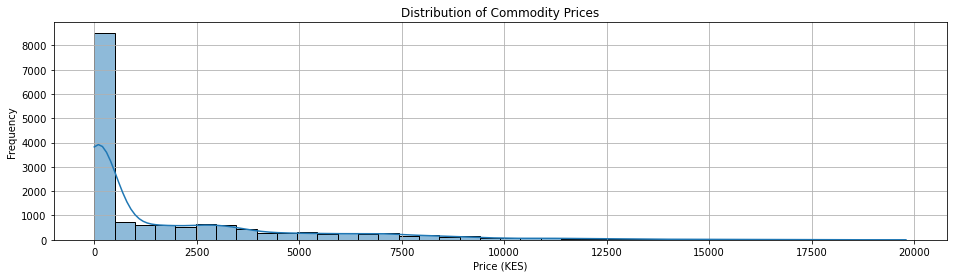

In [12]:
# Plotting the distribution of prices
plt.figure(figsize=(16, 4))
sns.histplot(data['price'], kde=True, bins= 40)
plt.title('Distribution of Commodity Prices')
plt.xlabel('Price (KES)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

The histogram shows a highly right-skewed distribution. This suggests that most commodity prices are on the lower end, with a few commodities having significantly higher prices.

The presence of a long tail indicates substantial variation in prices, with a small number of commodities being much more expensive than the majority.

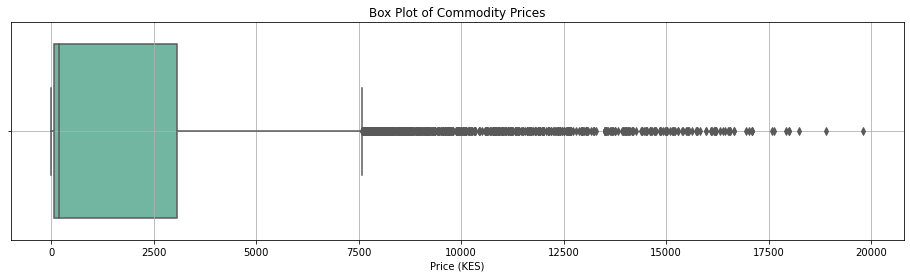

In [13]:
# Boxplot for commodity prices to identify outliers
plt.figure(figsize = (16, 4))
sns.boxplot(x = data['price'], palette = 'Set2')
plt.title('Box Plot of Commodity Prices')
plt.xlabel('Price (KES)')
plt.grid()
plt.show()

The box plot further illustrates the skewness in the data with many outliers on the higher end. These outliers represent commodities with exceptionally high prices.
The median price (indicated by the line inside the box) is relatively low compared to the maximum price, reinforcing the notion of a skewed distribution.

### 3.1.2 Comodity Frequencies
Let's create a bar plot to show the frequency of different commodities in the dataset. This will help us understand which commodities are most common and might be of greater interest for further analysis. ​

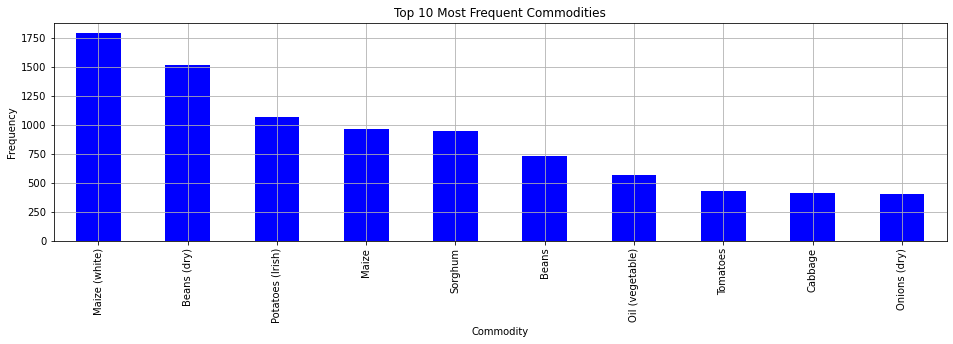

In [14]:
# Top 10 most frequent commodities in the dataset
top_commodities = data['commodity'].value_counts().head(10)

plt.figure(figsize=(16, 4))
top_commodities.plot(kind='bar', color='blue')
plt.title('Top 10 Most Frequent Commodities')
plt.xlabel('Commodity')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid()
plt.show()

### 3.1.3 District Distribution Analysis

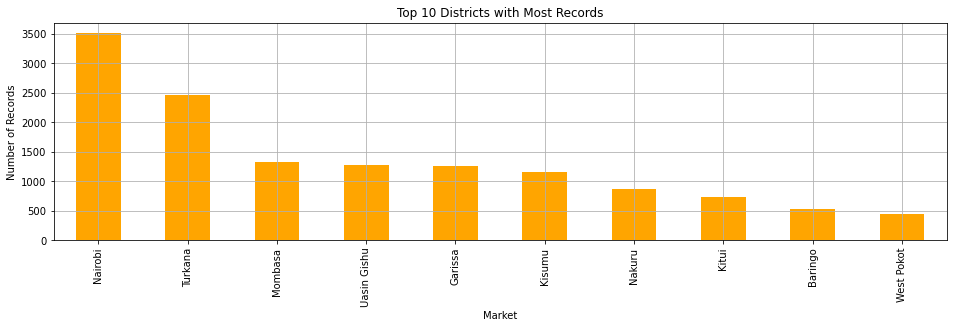

In [15]:
# Re-running the code for Top 10 districts with the most records in the dataset
top_markets = data['district'].value_counts().head(10)

plt.figure(figsize=(16, 4))
top_markets.plot(kind='bar', color='orange')
plt.title('Top 10 Districts with Most Records')
plt.xlabel('Market')
plt.ylabel('Number of Records')
plt.xticks(rotation=90)
plt.grid()
plt.show()


From this analysis we can see the top 10 districts with the most records in the dataset.
* Markets like **Nairobi**, **Turkana**, **Mombasa** and **Uasin Gishu** are among the most represented, indicating either their larger market size or more frequent data collection.

* This distribution helps in understanding which markets are most prominent in the dataset, which is important for evaluating the representativeness of our analysis and identifying any potential gaps in market coverage.

## 3.2 Bivariate Analysis
In this section, we'll explore relationships between two variables at a time. This can provide insights into how different variables interact with each other, which is particularly useful for understanding the dynamics of commodity prices in relation to other factors.

### 3.2.1 Commodity vs. Price
We'll start by analyzing the commodity prices have changed per variation. Before we do,  We first check the number and type of commodities we have.

In [16]:
# Checking for the value counts of each commodity.
data["commodity"].value_counts().sort_index(ascending=True)

Bananas                       327
Beans                         732
Beans (dolichos)              217
Beans (dry)                  1510
Beans (kidney)                107
Beans (mung)                   56
Beans (rosecoco)              240
Beans (yellow)                359
Bread                         178
Cabbage                       411
Cooking fat                   123
Cowpea leaves                  40
Cowpeas                       206
Fish (omena, dry)              24
Fuel (diesel)                  67
Fuel (kerosene)                67
Fuel (petrol-gasoline)         67
Kale                          387
Maize                         964
Maize (white)                1785
Maize (white, dry)            328
Maize flour                   387
Meat (beef)                   219
Meat (camel)                  122
Meat (goat)                   174
Milk (UHT)                    356
Milk (camel, fresh)            78
Milk (cow, fresh)              18
Milk (cow, pasteurized)       178
Millet (finger

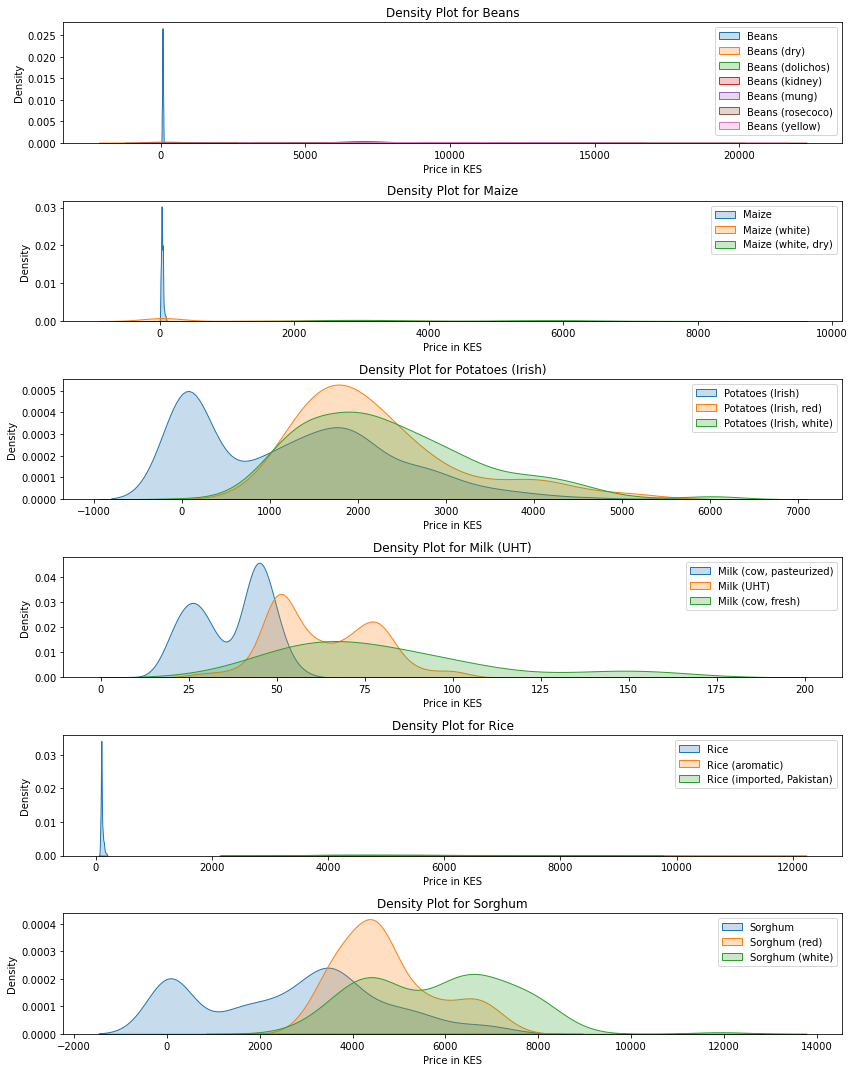

In [17]:
# List of commodity pairs/groups for comparison
commodity_groups = {
    'Beans': ['Beans', 'Beans (dry)', 'Beans (dolichos)','Beans (kidney)',
              'Beans (mung)','Beans (rosecoco)','Beans (yellow)'],

    'Maize': ['Maize', 'Maize (white)', 'Maize (white, dry)'],
    'Potatoes (Irish)': ['Potatoes (Irish)', 'Potatoes (Irish, red)',
                         'Potatoes (Irish, white)'],

    'Milk (UHT)': ['Milk (cow, pasteurized)', 'Milk (UHT)',
                   'Milk (cow, fresh)'],

    'Rice': ['Rice', 'Rice (aromatic)', 'Rice (imported, Pakistan)'],
    'Sorghum': ['Sorghum', 'Sorghum (red)', 'Sorghum (white)'],

}

# density plots for each commodity group
plt.figure(figsize=(12, 15))
for i, (group_name, commodities) in enumerate(commodity_groups.items(), 1):
    plt.subplot(len(commodity_groups), 1, i)
    for commodity in commodities:
        subset = data[data['commodity'] == commodity]
        sns.kdeplot(subset['price'], label=commodity, shade=True)
    plt.title(f'Density Plot for {group_name}')
    plt.xlabel('Price in KES')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

From the analysis we can see that there are multiple variant enries of some commodities. 
We'll go on to merge the commodities in order to simply our analysis moving on for a general analysis, the goal is to simplify the dataset while still capturing the essence of market variations.

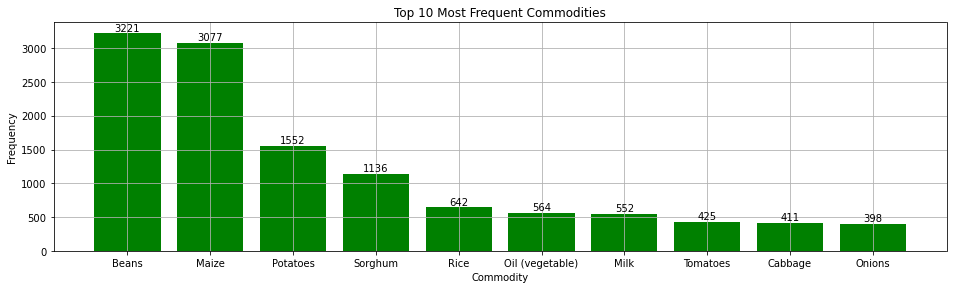

In [18]:
# Defining the mapping of variants to general categories
commodity_replacement = {
    'Beans (dry)': 'Beans',
    'Beans (kidney)': 'Beans',
    'Beans (rosecoco)': 'Beans',
    'Beans (yellow)': 'Beans',
    'Beans (dolichos)': 'Beans',
    'Beans (mung)': 'Beans',
    'Maize (white)': 'Maize',
    'Maize (white, dry)': 'Maize',
    'Potatoes (Irish)': 'Potatoes',
    'Potatoes (Irish, red)': 'Potatoes',
    'Potatoes (Irish, white)': 'Potatoes',
    'Rice (imported, Pakistan)':'Rice',
    'Rice (aromatic)' : 'Rice',
    'Sorghum (white)' : 'Sorghum',
    'Sorghum (red)' : 'Sorghum',
    'Onions (red)' : 'Onions',
    'Onions (dry)': 'Onions',
    'Milk (cow, pasteurized)':'Milk',
    'Milk (UHT)' : 'Milk',
    'Milk (cow, fresh)' : 'Milk'
}

# Updating the 'commodity' column by replacing variant names with the general category name
data['commodity'] = data['commodity'].replace(commodity_replacement)

# Confirming the changes
# Plotting the bar chart with value counts
plt.figure(figsize=(16, 4.2))
top_commodities = data['commodity'].value_counts().head(10)
bars = plt.bar(top_commodities.index, top_commodities.values, color='green')

# Adding the text with the value counts above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.title('Top 10 Most Frequent Commodities')
plt.xlabel('Commodity')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid()
plt.show()

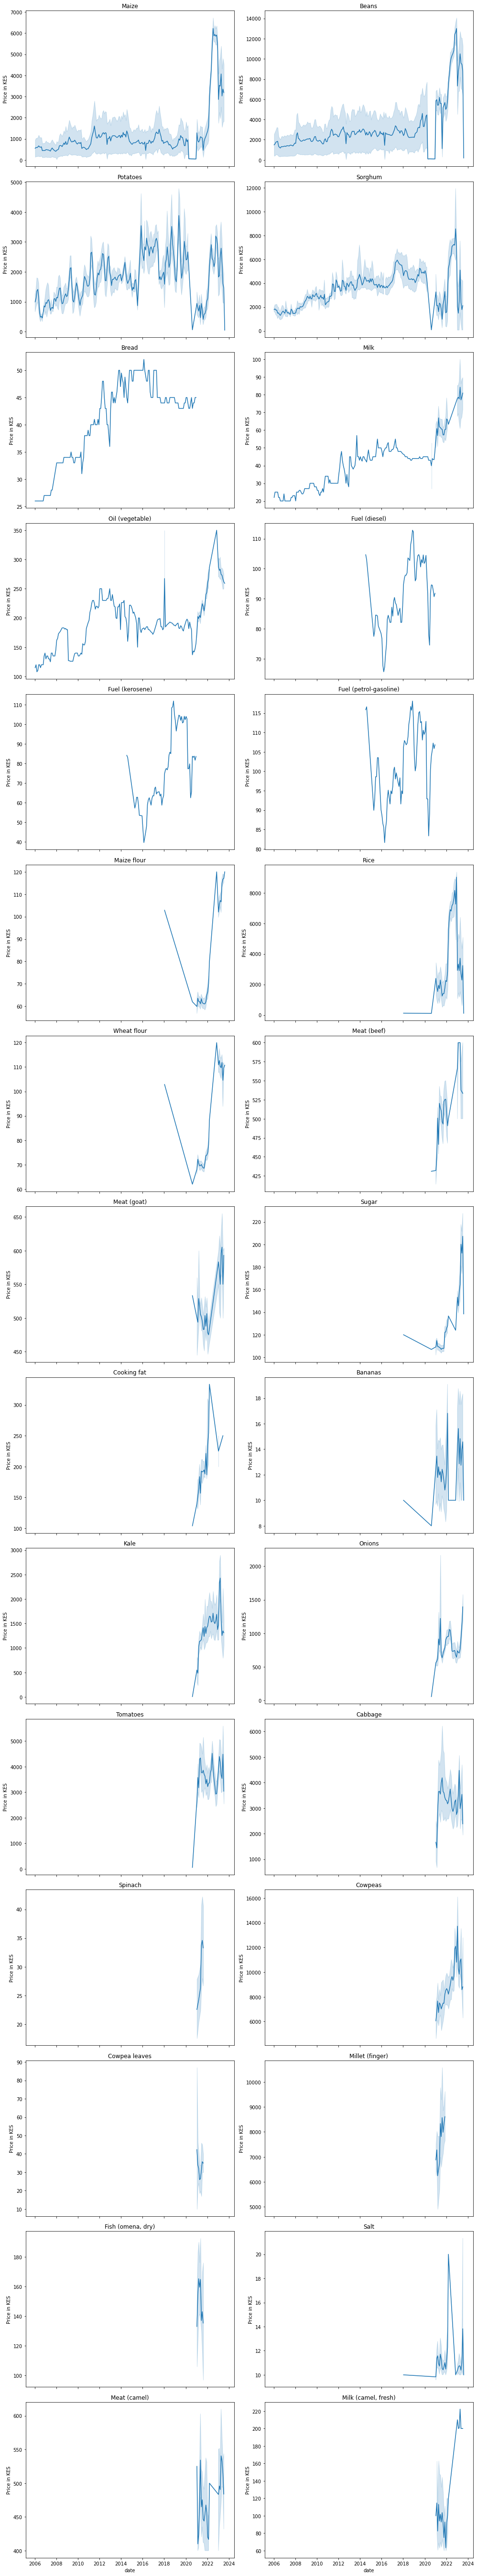

In [19]:
# Setting the date to index
data.set_index('date', inplace=True)

# Get the list of unique commodities
commodities = data['commodity'].unique()

# Calculating the number of rows for the subplots
num_rows = len(commodities) // 2 + (len(commodities) % 2 > 0)

# Setting up the matplotlib figure
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 5 * num_rows), sharex=True)

# Flattening the axes array for easy iteration
axes = axes.flatten()

# Plotting each commodity's price over time in a subplot
for i, commodity in enumerate(commodities):
    sns.lineplot(data=data[data['commodity'] == commodity]['price'], ax=axes[i])
    axes[i].set_title(commodity)
    axes[i].set_ylabel('Price in KES')

# Remove any unused subplots if commodities are an odd number
if len(commodities) % 2:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show();

From this visualization, we can see that not all the commodity prices have been recorded since 2006.
In order to reduce noise, We will go ahead and drop all the commodities that have not been recorded since 2006

In [20]:
# Filtering data to include only commodities with records starting from 2006 or earlier
commodities_since_2006 = data[data.index.year <= 2006]['commodity'].unique()

# Now filtering main dataframe to include only these commodities
filtered_data = data[data['commodity'].isin(commodities_since_2006)]

# After filtering we check the unique commodities and their counts again
filtered_commodity_counts = filtered_data['commodity'].value_counts()
filtered_commodity_counts

Beans              3221
Maize              3077
Potatoes           1552
Sorghum            1136
Oil (vegetable)     564
Milk                552
Bread               178
Name: commodity, dtype: int64

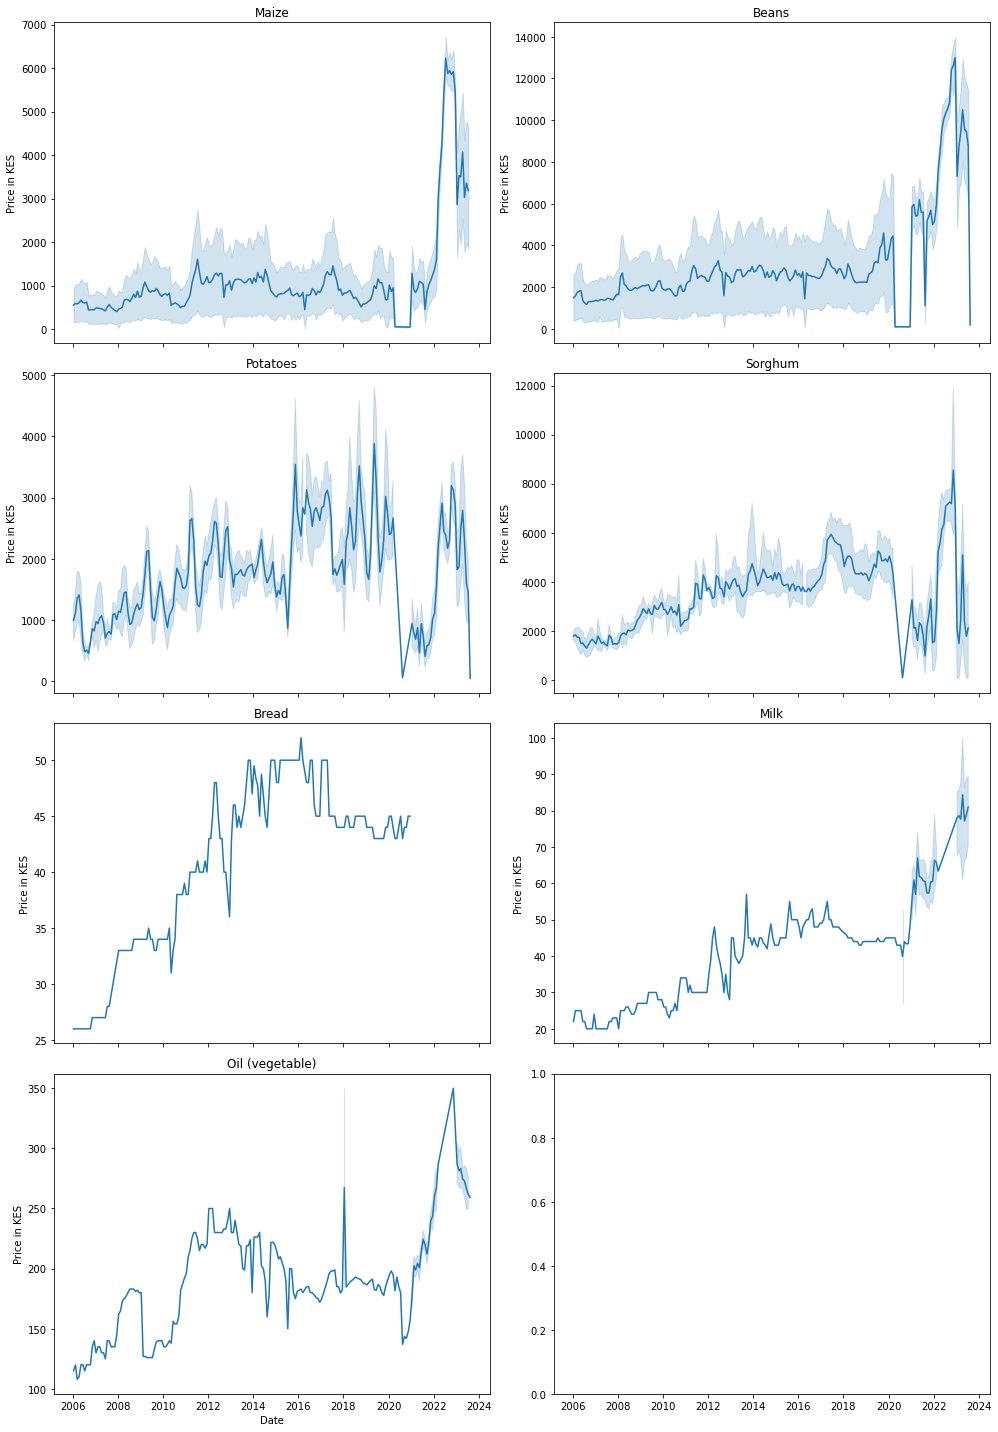

In [21]:
# Getting the list of unique commodities after filtering
commodities = filtered_data['commodity'].unique()

# Calculating the number of rows for the subplots
num_rows = len(commodities) // 2 + (len(commodities) % 2)

# Setying up the matplotlib figure
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 5 * num_rows), sharex=True)

# Flattening the axes array for easy iteration
axes = axes.flatten()

# Ploting each commodity's price over time in a subplot
for i, commodity in enumerate(commodities):
    sns.lineplot(data=filtered_data[filtered_data['commodity'] == commodity]['price'], ax=axes[i])
    axes[i].set_title(commodity)
    axes[i].set_ylabel('Price in KES')
    axes[i].set_xlabel('Date')

plt.tight_layout()
plt.show();

Great. Now that we have commoditie with substatial data, we can proceed to the next level of our analysis.

### 3.2.2 Price vs. District
Next, we'll examine the relationship between commodity prices and different districts. This can highlight regional price variations.

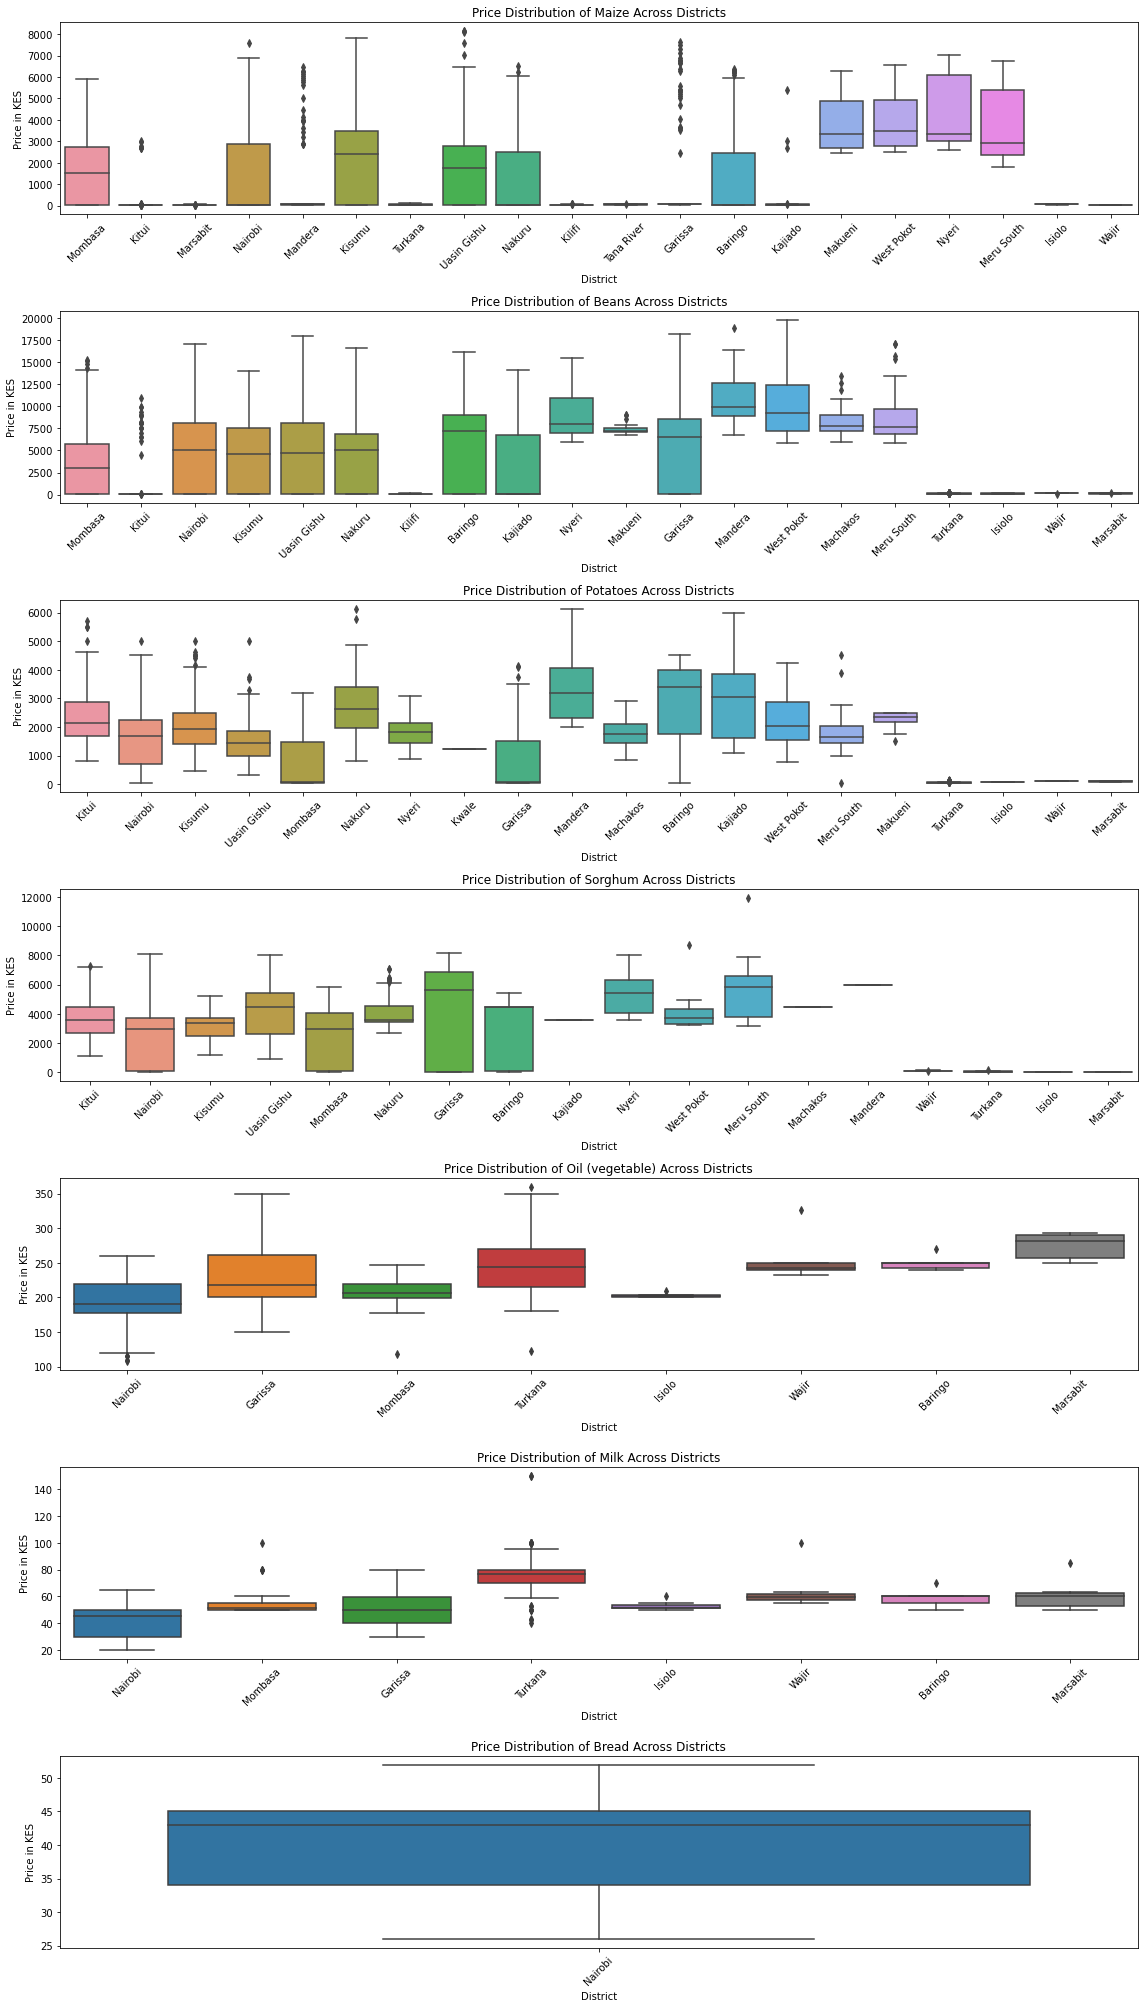

In [22]:
# Selecting the commodities for visualization
key_commodities = ['Maize', 'Beans', 'Potatoes', 'Sorghum', 'Oil (vegetable)', 'Milk', 'Bread' ]

# Seting up the matplotlib figure - adjust the size as needed
num_rows = len(key_commodities)
fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(16, 4*num_rows))

# Flattening the axes array if it's multidimensional
axes = axes.flatten() if num_rows > 1 else [axes]

# box plots for each commodity's price across districts
for i, commodity in enumerate(key_commodities):
    sns.boxplot(data=filtered_data[filtered_data['commodity'] == commodity], x='district', y='price', ax=axes[i])
    axes[i].set_title(f'Price Distribution of {commodity} Across Districts')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].set_ylabel('Price in KES')
    axes[i].set_xlabel('District')

plt.tight_layout()
plt.show();

from this analysis, We cans see that
* **Maize** prices vary widely across districts, with some having higher median prices and greater variability, suggesting regional factors influence prices.
* **Beans** also exhibit significant variation, indicating occasional spikes possibly due to seasonal shortages.
* **Potato** prices are relatively consistent across districts, with occasional outliers indicating price surges.
* **Sorghum** prices vary notably, reflecting regional differences in its importance.
* **Vegetable oil** prices are relatively uniform, but some districts show greater price ranges.
* **Milk prices** show less variability, suggesting a more consistent supply chain, though occasional fluctuations occur.
* **Limited data on bread** prices hinders comparative district analysis so we will go on and drop the commodity all together

In [23]:
# Filtering and maintaining rows where the commodity is not "Bread"
filtered_data = filtered_data[filtered_data['commodity'] != 'Bread']
filtered_commodity_counts = filtered_data['commodity'].value_counts()
filtered_commodity_counts

Beans              3221
Maize              3077
Potatoes           1552
Sorghum            1136
Oil (vegetable)     564
Milk                552
Name: commodity, dtype: int64

### 3.2.3 Unit vs Commodity
Next we'll analyse our data to understand how many different units we have recorderd per each commodity.

In [24]:
# Grouping for analysis
unit_analysis = filtered_data.groupby(['commodity', 'unit']).size().reset_index(name='count')

# Sorting the results for better readability
unit_analysis = unit_analysis.sort_values(by=['commodity', 'count'], ascending=[True, False])

# Displaying the dataframe
unit_analysis

,commodity,unit,count
0,Beans,90 KG,1712
1,Beans,KG,1509
3,Maize,KG,2016
2,Maize,90 KG,1061
5,Milk,500 ML,533
6,Milk,L,18
4,Milk,200 ML,1
7,Oil (vegetable),L,564
8,Potatoes,50 KG,1189
9,Potatoes,KG,363


* **Beans:** The majority of bean prices are recorded in '90 KG' units, followed by 'KG'. This suggests that beans are commonly traded in bulk.

* **Maize:** Maize prices are commonly reported in both 'KG' and '90 KG', with more records in 'KG'. This reflects the different market segments (retail vs. wholesale).

* **Milk:** Milk is primarily measured in '500 ML' units, with very few records in 'L' and '200 ML'. The dominance of the '500 ML' unit indicates standard packaging size for milk.

* **Oil (Vegetable):** All records for vegetable oil are in liters, which indicates consistency in the unit of measurement for vegetable oil.

* **Potatoes:** Potatoes also have a significant number of records in '50 KG' suggesting bulk trade, but there are also a substantial number of records in 'KG' which might represent smaller purchases or retail sales.

* **Sorghum:** The unit '90 KG' is used for most of the sorghum records, with fewer in 'KG'. This is indicative of bulk trade for sorghum.

To compare prices across all commodities we'll need to standardize the units of measure. For solid commodities like beans, maize, and sorghum, 'KG' could be the standard unit. For the liquids, 'L' (liter) could be the standard.

In [25]:
# Defining the conversion factors
conversion_factors = {
    '90 KG': 1/90,   # Converting prices for 90 KG to price per KG
    'KG': 1,         # No conversion needed
    '500 ML': 2,     # Converting prices for 500 ML to price per L
    'L': 1,          # No conversion needed
    '50 KG': 1/50,   # Converting prices for 50 KG to price per KG
    '200 ML': 5      # Converting prices for 200 ML to price per L
}

# Applying the conversion factors to create a new 'standardized_price' column
filtered_data['standardized_price'] = filtered_data.apply(
    lambda row: row['price'] * conversion_factors.get(row['unit'], 1), axis=1
)

filtered_data = filtered_data.reset_index()
filtered_data = filtered_data.rename(columns={"index":'date'})

# Saving the updated DataFrame to a new CSV file
#filtered_data.to_csv('Data/filtered_data.csv', index=False)

# Sampling the data to confirm the changes
filtered_data.sample(10)

,date,district,market,commodity,unit,pricetype,currency,price,standardized_price
6994,2021-12-15,Nakuru,Wakulima (Nakuru),Sorghum,90 KG,Wholesale,KES,4500.00,50.000000
7282,2022-05-15,Mandera,Takaba (Mandera),Maize,90 KG,Wholesale,KES,5040.00,56.000000
3846,2016-03-15,Kilifi,Kilifi,Beans,KG,Retail,KES,84.00,84.000000
1794,2010-12-15,Uasin Gishu,Eldoret town (Uasin Gishu),Beans,KG,Wholesale,KES,56.66,56.660000
1958,2011-06-15,Kitui,Kitui,Beans,KG,Retail,KES,85.00,85.000000
1085,2009-02-15,Nairobi,Nairobi,Oil (vegetable),L,Retail,KES,127.00,127.000000
4586,2017-09-15,Marsabit,Marsabit,Maize,KG,Retail,KES,53.00,53.000000
5212,2018-11-15,Nakuru,Nakuru,Maize,KG,Wholesale,KES,17.42,17.420000
2602,2013-03-15,Nairobi,Nairobi,Potatoes,50 KG,Wholesale,KES,1886.66,37.733200
5259,2018-12-15,Nakuru,Nakuru,Sorghum,90 KG,Wholesale,KES,3500.00,38.888889


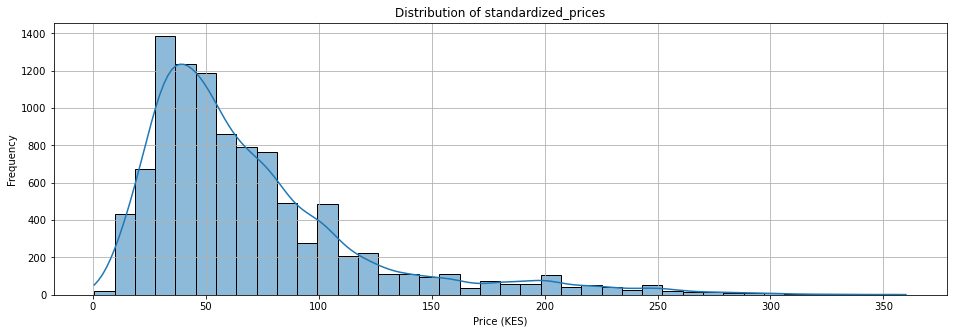

In [26]:
# Plotting the distribution of prices
plt.figure(figsize=(16, 5))
sns.histplot(filtered_data['standardized_price'], kde=True, bins= 40)
plt.title('Distribution of standardized_prices')
plt.xlabel('Price (KES)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

### 3.2.4  Commodity vs  PriceType
Next we'll analyse our data to understand the pricetype distribution per each commodity.

In [27]:
# Grouping the data by commodity and price type
price_type_analysis = filtered_data.groupby(['commodity', 'pricetype']).size().reset_index(name='count')

# Sorting the results for better readabilityc
price_type_analysis = price_type_analysis.sort_values(by=['commodity', 'count'], ascending=[True, False])

# Checking the results
price_type_analysis

,commodity,pricetype,count
1,Beans,Wholesale,2444
0,Beans,Retail,777
3,Maize,Wholesale,1693
2,Maize,Retail,1384
4,Milk,Retail,552
5,Oil (vegetable),Retail,564
7,Potatoes,Wholesale,1189
6,Potatoes,Retail,363
9,Sorghum,Wholesale,902
8,Sorghum,Retail,234


**Beans:** The majority of price records for beans are for wholesale prices, which are more than three times the records for retail prices. This suggests that beans are commonly traded in bulk, and wholesale prices are more frequently reported.

**Maize:** Wholesale prices for maize also have a higher count compared to retail, but the difference is not as pronounced as with beans. This indicates a significant presence of maize in both wholesale and retail markets.

**Milk:** All price records for milk are retail, indicating that the dataset might be capturing consumer prices rather than bulk trading prices.

**Oil (Vegetable):** Similar to milk, all records for vegetable oil are retail prices, suggesting the data reflects end-consumer pricing.

**Potatoes:** The count of wholesale price records is significantly higher than retail for potatoes, indicating a focus on bulk trade within the dataset for this commodity.

**Sorghum:** Wholesale price records outnumber retail ones.

### 3.2.5 Temporal Analysis:
Now we'll check how the standardized prices of commodities fluctuate over time due to various factors such as seasonality, demand, broader economic conditions and supply changes.

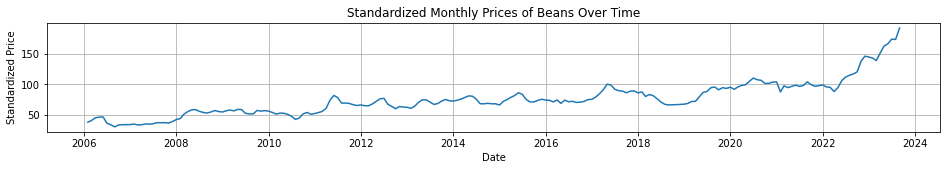

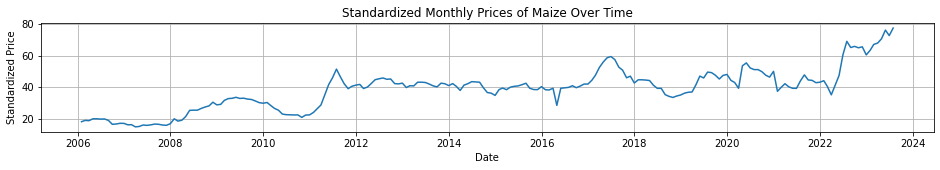

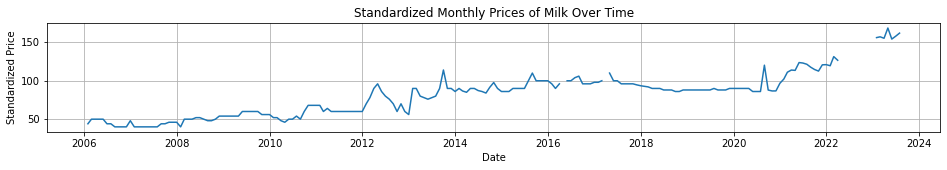

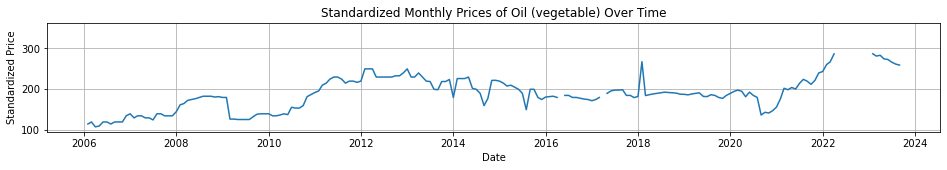

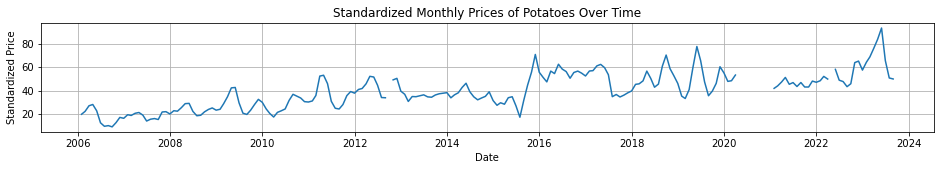

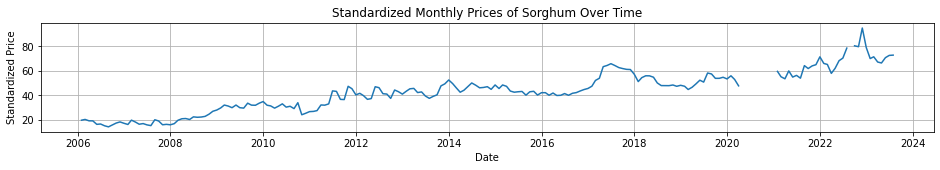

In [28]:
# Grouping by 'commodity' and resample to get monthly means
filtered_data.set_index('date', inplace=True)# Setting the date to index
grouped = filtered_data.groupby('commodity').resample('M')['standardized_price'].mean()

# Resetting the index
grouped = grouped.reset_index()

# Plotting each commodity
commodities = grouped['commodity'].unique()
for commodity in commodities:
    plt.figure(figsize=(16, 2))
    sns.lineplot(
        data=grouped[grouped['commodity'] == commodity],
        x='date',
        y='standardized_price'
    )
    plt.title(f'Standardized Monthly Prices of {commodity} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Standardized Price')
    plt.grid()
    plt.show()

filtered_data = filtered_data.reset_index()
filtered_data = filtered_data.rename(columns={"index":'date'})

The visualizations indicate both **seasonal patterns and long-term trends** in the prices of commodities. These patterns are critical for any predictive modeling efforts.
The fluctuations and trends can be influenced by a variety of factors including **market demand**, **supply chain issues**, **seasonal harvests**, and **broader economic conditions**.
Our predictive model will need to account for these temporal dynamics.

### 3.3 Outlier Detection:
Next we analyse our data to Identify any outliers since they can distort predictive modeling and can be indicative of data entry errors, unusual market conditions, or true price spikes.

In [29]:
# Creating a function to calculate IQR and identify outliers
def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# We will now apply this function to each commodity group in our dataset
outliers_by_commodity = {}

for commodity in filtered_data['commodity'].unique():
    commodity_data = filtered_data[filtered_data['commodity'] == commodity]['standardized_price']
    outliers = detect_outliers_iqr(commodity_data)
    outliers_by_commodity[commodity] = outliers

# Displaying the outliers for each commodity
for commodity, outliers in outliers_by_commodity.items():
    print(f"Outliers for {commodity}:")
    print(outliers)
    print("\n")

Outliers for Maize:
2617      82.700000
2648      87.800000
2680      84.750000
2709      86.350000
2732      83.000000
2924      84.000000
3936      84.000000
4276      87.000000
4359      90.700000
4401      92.600000
4407      87.900000
4444      98.000000
4488     100.000000
4529      91.000000
4570      88.000000
4613      87.000000
4828      85.500000
4870      86.300000
4910      85.000000
4954      84.000000
4998      83.000000
5704      85.000000
5942      84.000000
5977      83.000000
7421      90.311111
7519      85.000000
7823      83.333333
7933      84.500000
7963      83.688889
7978      90.422222
7999      84.122222
8013      87.033333
8025      90.000000
9798      85.560000
9804      87.500000
9876      85.000000
9893      90.000000
9907      87.500000
9928     100.000000
9934      90.000000
9938      85.000000
9944      95.000000
9961      92.500000
9965      90.000000
9995      90.000000
10007     90.000000
10016     84.000000
10051     95.000000
10067    100.000000


* **Maize:** Numerous outliers observed between 2013 and 2023, with notable spikes in 2017 and 2023.
Potential indicators of market stress, supply issues, or external factors impacting prices.
* **Beans:** Outliers concentrated in 2021 and 2023, reaching up to 220 units.
Suggestive of high demand or reduced supply, prompting further investigation into market conditions.
* **Potatoes:** Outliers across multiple years, highest prices recorded in 2018 and 2023.
Persistent outliers indicate recurring factors affecting the potato market, potentially linked to seasonal weather impacts.
* **Sorghum:** Fewer outliers compared to other commodities, significant spikes in 2021 and 2023.
* **Milk:** No outliers detected, indicating consistent milk prices without extreme spikes or dips.
* **Oil (Vegetable):** Sporadic outliers across the dataset's timeline, significant spikes in 2018, 2022, and 2023.
Possibly linked to global oil prices or shifts in trade policies, as vegetable oil prices are influenced by international markets. 

* **Limitations**: Price trends in the different Districts could be affected by multiple factore includung demand and supply and Transport and Production cost. WIth that in mind, we will not be dropping the outliers in this case.

### 3.4. Analysing the Nairobi District data

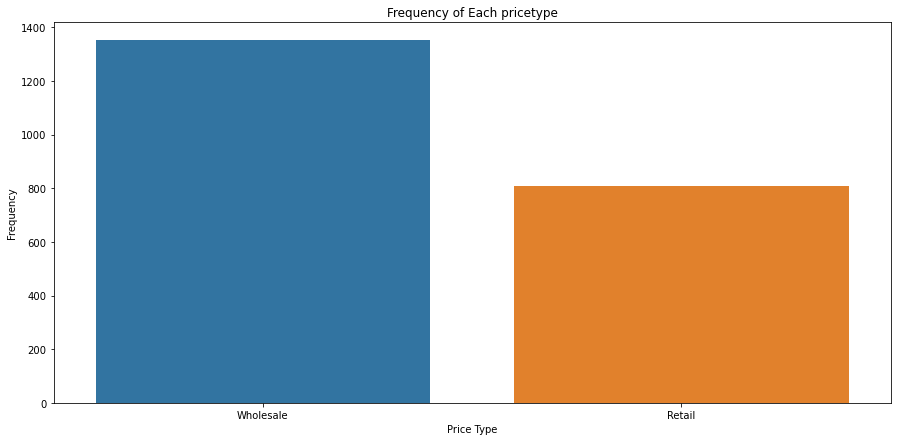

In [30]:
# Bar plot visualization to explore the the frequency distribution of different price types within the 'Nairobi' district 
district_counts = filtered_data[filtered_data['district']=='Nairobi']['pricetype'].value_counts()

plt.figure(figsize=(15, 7))
sns.barplot(x=district_counts.index, y=district_counts.values)
plt.title('Frequency of Each pricetype')
plt.xlabel('Price Type')
plt.ylabel('Frequency')
plt.show()

1. Wholesale emerges as the predominant price type in the Nairobi district.
2. This prevalence may stem from a higher concentration of data collection in markets where small-scale traders procure goods for subsequent retail sales.

In [31]:
# Droping the specified columns from the  filtered_data DataFrame since we wont use the columns during the modelling stage
columns_to_drop = ['market', 'unit', 'currency', 'price']
filtered_data.drop(columns=columns_to_drop, inplace=True)

In [32]:
# Extracting the Nairobi district markets data from the filtered_data DataFrame
df_nairobi = filtered_data[filtered_data['district'] == 'Nairobi']
df_nairobi.shape

(2160, 5)

In [33]:
df_nairobi.head()

,date,district,commodity,pricetype,standardized_price
8,2006-01-15,Nairobi,Maize,Wholesale,15.480000
9,2006-01-15,Nairobi,Maize,Wholesale,15.544444
10,2006-01-15,Nairobi,Potatoes,Wholesale,13.288600
11,2006-01-15,Nairobi,Sorghum,Wholesale,21.777778
12,2006-01-15,Nairobi,Milk,Retail,44.000000


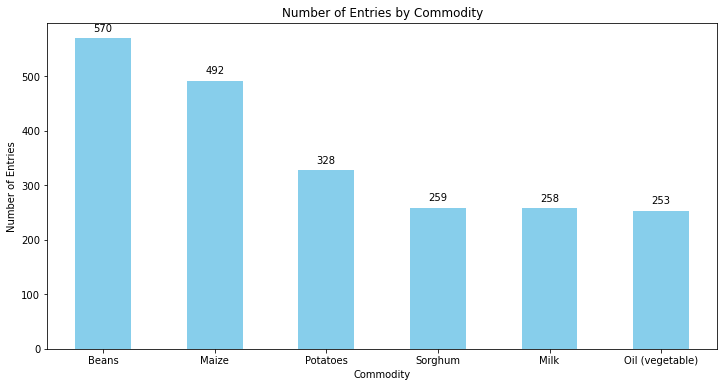

In [34]:
commodity_counts = df_nairobi['commodity'].value_counts()

# Plotting
plt.figure(figsize=(12, 6))
ax = commodity_counts.plot(kind='bar', color='skyblue')

# Adding annotations on top of the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Number of Entries by Commodity')
plt.xlabel('Commodity')
plt.ylabel('Number of Entries')
plt.xticks(rotation=0)
plt.show()

1. The primary commodities consumed in markets within the Nairobi district are beans, maize, and potatoes.
2. This distribution provides insights into the preferences of customers within the district.
3. Additionally, this pattern may be attributed to the affordability of these products and their versatility.

Since Beans had the highest entries, we'll go to the next level and prepare our beans data to build a time series model to predict it's prices before applying the same strategy to the other commodities.

## 4. Data Preprocessing 

In [35]:
# Filtering the dataset for Beans in Nairobi and for wholesale prices only
Beans_df = df_nairobi[(df_nairobi['commodity'] == 'Beans') & 
                      (df_nairobi['district'] == 'Nairobi') & 
                      (df_nairobi['pricetype'] == 'Wholesale')]

# Size of the filtered dataset
dataset_size = Beans_df.shape

# Descriptive statistics for the relevant features
descriptive_stats = Beans_df.describe(include='all')

dataset_size, descriptive_stats

((495, 5),
                        date district commodity  pricetype  standardized_price
 count                   495      495       495        495          495.000000
 unique                  202        1         1          1                 NaN
 top     2021-10-15 00:00:00  Nairobi     Beans  Wholesale                 NaN
 freq                     11      495       495        495                 NaN
 first   2006-01-15 00:00:00      NaN       NaN        NaN                 NaN
 last    2023-07-15 00:00:00      NaN       NaN        NaN                 NaN
 mean                    NaN      NaN       NaN        NaN           78.152792
 std                     NaN      NaN       NaN        NaN           33.724477
 min                     NaN      NaN       NaN        NaN           12.600000
 25%                     NaN      NaN       NaN        NaN           54.688333
 50%                     NaN      NaN       NaN        NaN           68.890000
 75%                     NaN      NaN    

In [36]:
# Sorting the dataset based on the index (date)
Beans_df.sort_index(inplace=True)

# Displaying the first few rows to verify changes
Beans_df.head()

,date,district,commodity,pricetype,standardized_price
14,2006-01-15,Nairobi,Beans,Wholesale,42.310000
15,2006-01-15,Nairobi,Beans,Wholesale,35.277778
41,2006-02-15,Nairobi,Beans,Wholesale,47.100000
42,2006-02-15,Nairobi,Beans,Wholesale,38.722222
70,2006-03-15,Nairobi,Beans,Wholesale,42.310000


In [37]:
# Checking for missing values in 'standardized_price'
missing_values = Beans_df['standardized_price'].isnull().sum()

# Checking the frequency of the date entries
date_frequency = Beans_df.index.to_series().diff().unique()

missing_values, date_frequency

(0,
 array([ nan,   1.,  26.,  28.,  27.,  24.,  25.,  29.,  30.,  31.,  32.,
         33.,  35.,  40.,  38.,  39.,  42.,  41.,  55.,  43.,  44.,  36.,
         23., 173.,   2.,  72.,   5.,  81.,  86.,  83.,   4.,  87.,  94.,
         59.,  52.,  76.,   3.,  78.,  66.,  60.,  61.,  63.,  48.,  57.,
         53.,  34.]))

In [38]:
# Convert 'date' to datetime format and set as index
Beans_df.loc[:, 'date'] = pd.to_datetime(Beans_df['date'])
Beans_df.set_index('date', inplace=True)

# Sort the dataset based on the index (date)
Beans_df.sort_index(inplace=True)

# Resampling the data to a monthly frequency, taking the average of prices in each month
monthly_Beans_df = Beans_df['standardized_price'].resample('M').mean()

# Displaying the first few rows of the resampled data
monthly_Beans_df.head()

date
2006-01-31    38.793889
2006-02-28    42.911111
2006-03-31    42.043889
2006-04-30    47.494444
2006-05-31    49.887778
Freq: M, Name: standardized_price, dtype: float64

In [39]:
# Checking for missing values in the resampled monthly data
missing_values_monthly = monthly_Beans_df.isnull().sum()

# Filling missing values with the mean (if any)
monthly_Beans_filled_df = monthly_Beans_df.fillna(monthly_Beans_df.mean())

# Rechecking for missing values after filling
recheck_missing_values = monthly_Beans_filled_df.isnull().sum()

missing_values_monthly, recheck_missing_values

(9, 0)

### 4.1 Checking for Stationarity 

In [40]:
# Trying the Augmented Dickey-Fuller test for stationarity on the filled dataset
adf_test_result_filled = adfuller(monthly_Beans_filled_df)

# Extracting the p-value from the test results
adf_p_value_filled = adf_test_result_filled[1]

adf_p_value_filled

0.9691132706095686

The Augmented Dickey-Fuller (ADF) test on the filled dataset yields a p-value of approximately **0.97**. In the context of the ADF test:
A high p-value (typically > 0.05) suggests that the null hypothesis of the presence of a unit root (i.e., non-stationarity) cannot be rejected. In this case our data is not stationary and we'll need to go ahead and do some transformations.

### 4.2 Differencing and decomposing

2.4703476634094467e-29

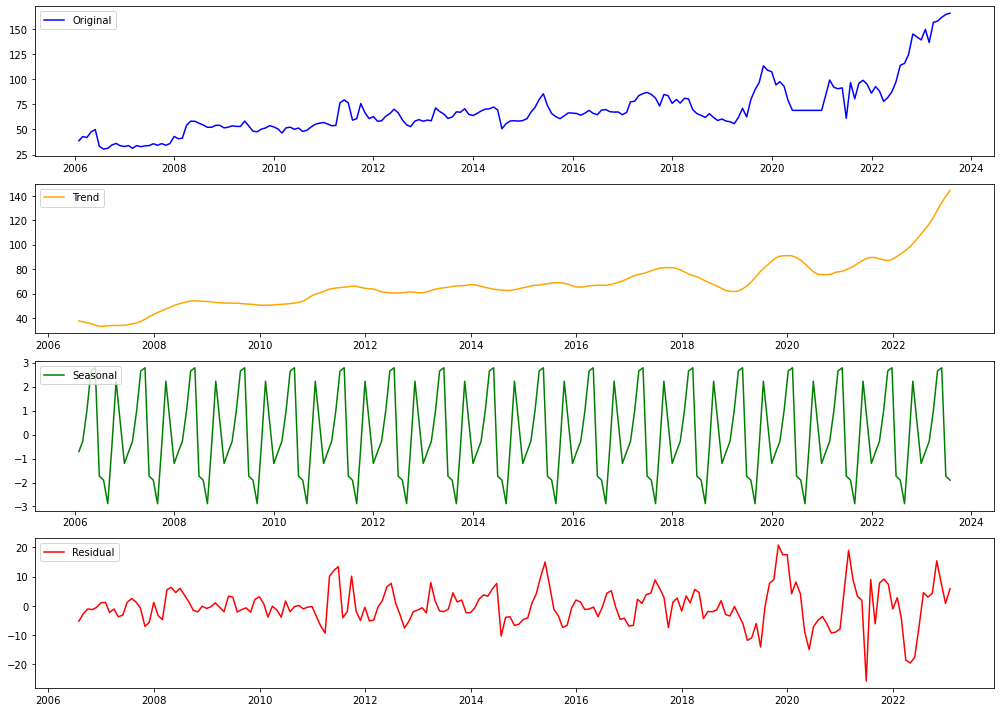

In [41]:
# Applying differencing to make the series stationary
monthly_beans_diff = monthly_Beans_filled_df.diff().dropna()

# Performing the Augmented Dickey-Fuller test again on the differenced data
adf_test_result_diff = adfuller(monthly_beans_diff)
adf_p_value_diff = adf_test_result_diff[1]

# Seasonality and trend analysis using seasonal decomposition
decomposition = seasonal_decompose(monthly_Beans_filled_df, model='additive')

# Plotting the original series, trend, seasonal, and residual components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(monthly_Beans_filled_df, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.tight_layout()

adf_p_value_diff

## 5. Modelling
Now that we've made our data stationary, We can proceed on to start modeling. Will first split our data to Train and test data, then build our baseline model.

In [42]:
# Splitting our dataset into training and testing sets
# We'll use 80% of the data for training and 20% for testing
train_size = int(len(monthly_beans_diff) * 0.8)
train_data, test_data = monthly_beans_diff[0:train_size], monthly_beans_diff[train_size:]

# Checking the sizes of the training and testing sets
train_data_size = train_data.shape[0]
test_data_size = test_data.shape[0]

train_data_size, test_data_size

(168, 42)

### 5.1 Baseline Model

In [43]:
from statsmodels.tsa.arima.model import ARIMA
# Function to train and evaluate an ARIMA model
def train_evaluate_arima(train, test, arima_order):
    """
    Train an ARIMA model and evaluate its performance.
    
    :param train: Training dataset
    :param test: Testing dataset
    :param arima_order: Tuple of ARIMA parameters (p, d, q)
    :return: Root Mean Squared Error (RMSE) of the model
    """
    history = [x for x in train]
    predictions = []
    
    # Walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # Calculate and return RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse, predictions

In [44]:
# Baseline ARIMA mode
arima_order = (1, 2, 1)
baseline_rmse, baseline_predictions = train_evaluate_arima(train_data, test_data, arima_order)

baseline_rmse

13.899761944108665

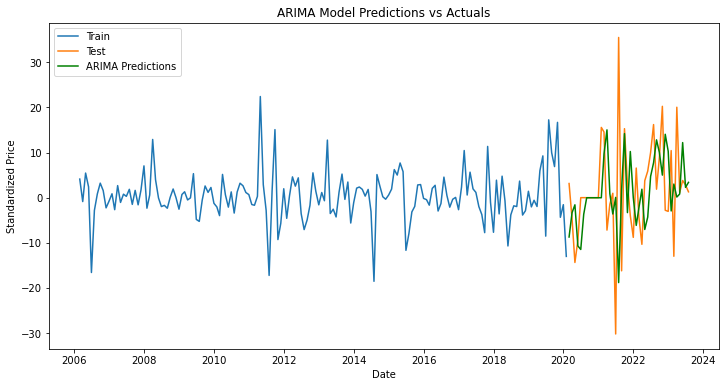

In [45]:
# Fit the ARIMA model
model = ARIMA(train_data, order=arima_order)
model_fit = model.fit()

model_fit.summary()

# Visualize actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, baseline_predictions, label='ARIMA Predictions', color='green')
plt.title('ARIMA Model Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Standardized Price')
plt.legend()
plt.show()

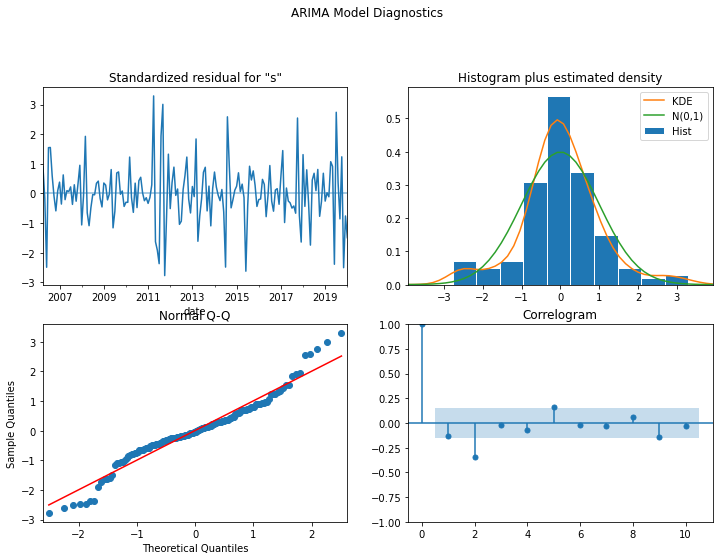

In [46]:
# Plot diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle('ARIMA Model Diagnostics', y=1.02)
plt.show()

### 5.2 Model 2

In [47]:
# SARIMA Order
sarima_order = (1, 1, 1, 12)  # (p, d, q, S) for seasonal order - S is 12 for monthly data
# Train and fit the SARIMA model
sarima_model = SARIMAX(train_data, order=(2, 1, 2), seasonal_order=sarima_order)
sarima_model_fit = sarima_model.fit(disp=False)
sarima_model_fit.summary()

# Forecasting
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test_data))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Calculate RMSE
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast_mean))
print(f'SARIMA 1 RMSE: {sarima_rmse:.2f}')

SARIMA 1 RMSE: 11.66


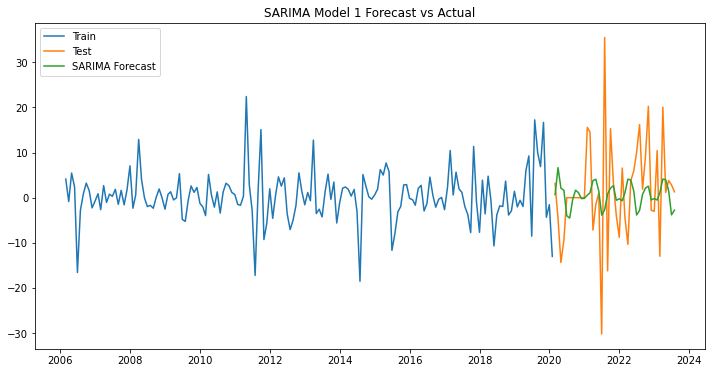

In [48]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(sarima_forecast_mean.index, sarima_forecast_mean, label='SARIMA Forecast')
plt.title('SARIMA Model 1 Forecast vs Actual')
plt.legend()
plt.show()

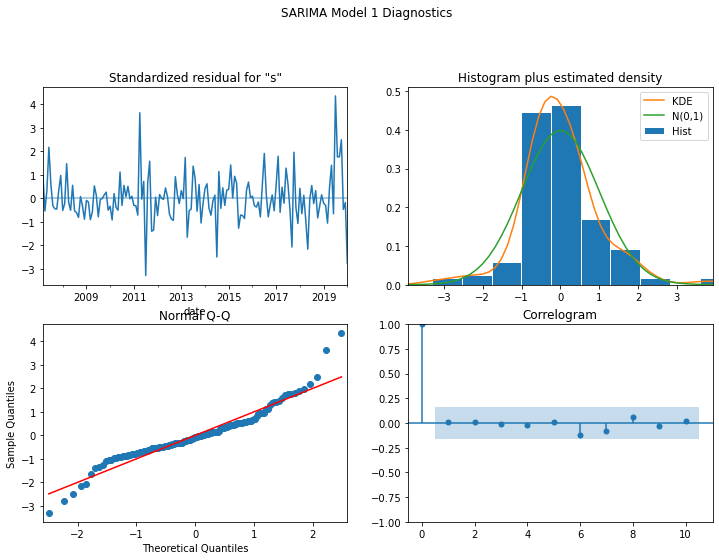

In [49]:
# Plot diagnostics
sarima_model_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle('SARIMA Model 1 Diagnostics', y=1.02)
plt.show()

### 5.3 Model 3

In [50]:
# SARIMA Order
sarima_order = (1, 2, 1, 12)  # (p, d, q, S) for seasonal order - S is 12 for monthly data
# Train and fit the SARIMA model
sarima_model = SARIMAX(train_data, order=(2, 1, 2), seasonal_order=sarima_order)
sarima_model_fit2 = sarima_model.fit(disp=False)
sarima_model_fit2.summary()

# Forecasting
sarima_forecast = sarima_model_fit2.get_forecast(steps=len(test_data))
sarima_forecast_mean2 = sarima_forecast.predicted_mean

# Calculating RMSE
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast_mean2))
print(f'SARIMA 2 RMSE: {sarima_rmse:.2f}')

SARIMA 2 RMSE: 11.60


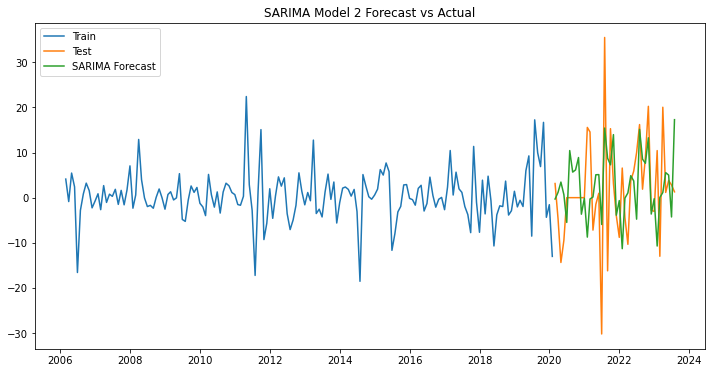

In [51]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(sarima_forecast_mean.index, sarima_forecast_mean2, label='SARIMA Forecast')
plt.title('SARIMA Model 2 Forecast vs Actual')
plt.legend()
plt.show()

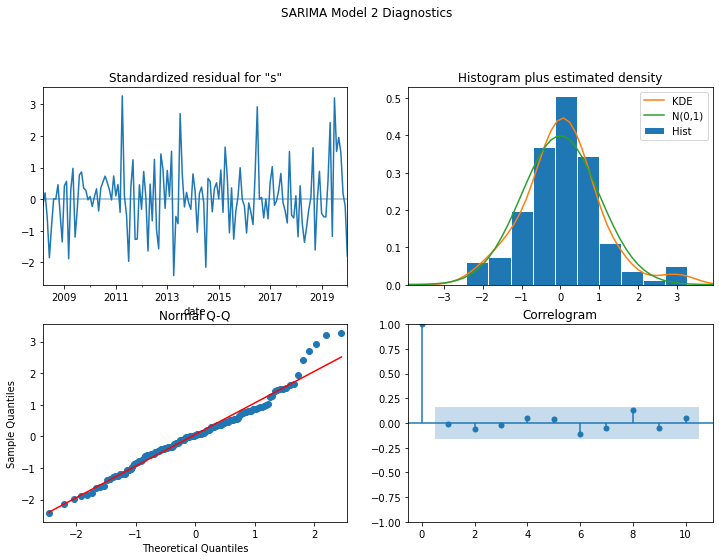

In [52]:
# Plot diagnostics
sarima_model_fit2.plot_diagnostics(figsize=(12, 8))
plt.suptitle('SARIMA Model 2 Diagnostics', y=1.02)
plt.show()

SARIMA 3 RMSE: 11.58


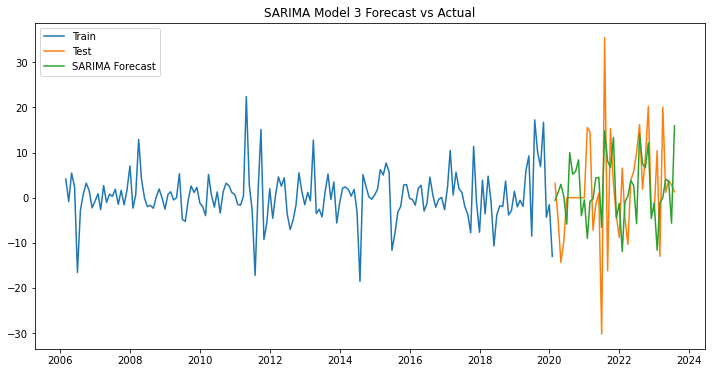

In [53]:
# SARIMA Order
sarima_order = (1, 2, 1, 12)  # (p, d, q, S) for seasonal order - S is 12 for monthly data
# Train and fit the SARIMA model
sarima_model = SARIMAX(train_data, order=(1, 0, 2), seasonal_order=sarima_order)
sarima_model_fit3 = sarima_model.fit(disp=False)
sarima_model_fit3.summary()

# Forecasting
sarima_forecast = sarima_model_fit3.get_forecast(steps=len(test_data))
sarima_forecast_mean3 = sarima_forecast.predicted_mean

# Calculating RMSE
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast_mean3))
print(f'SARIMA 3 RMSE: {sarima_rmse:.2f}')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(sarima_forecast_mean.index, sarima_forecast_mean3, label='SARIMA Forecast')
plt.title('SARIMA Model 3 Forecast vs Actual')
plt.legend()
plt.show()

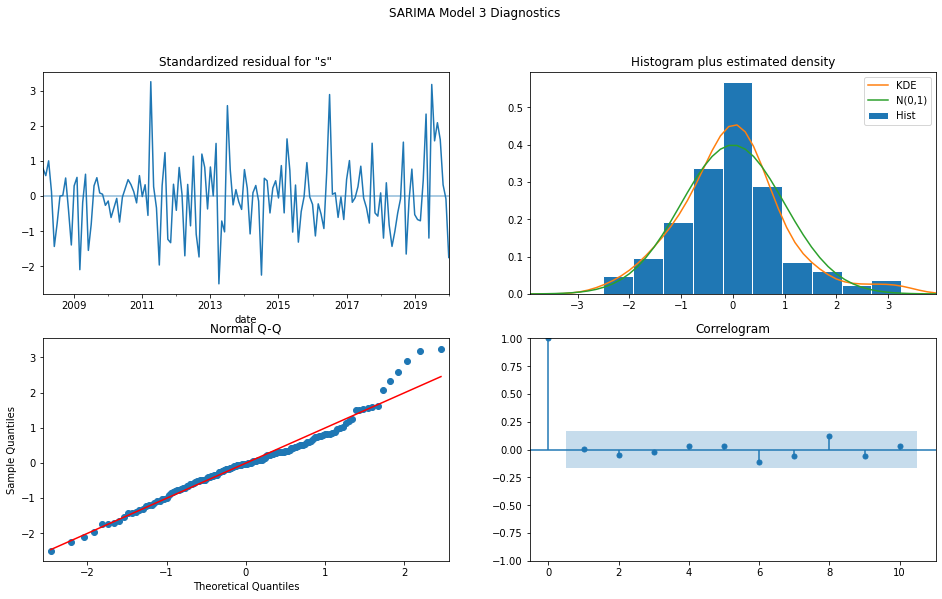

In [54]:
# Plotting diagnostics
sarima_model_fit3.plot_diagnostics(figsize=(16, 9))
plt.suptitle('SARIMA Model 3 Diagnostics')
plt.show()

### 5.4: Auto ARIMA

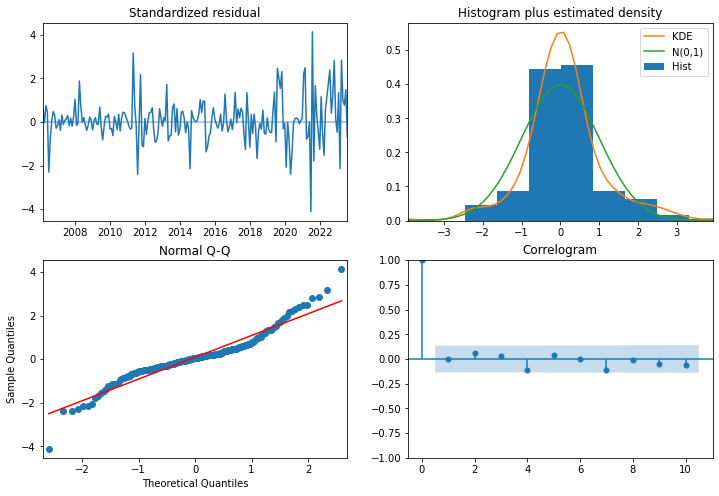

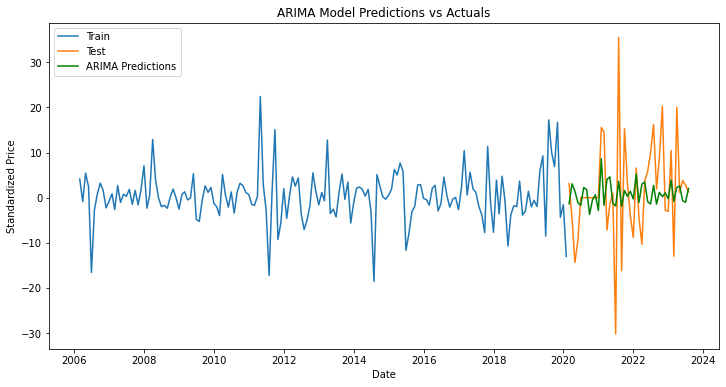

RMSE: 10.723215155798716


In [59]:
# Fitting the Auto SARIMA model
model = pm.auto_arima(monthly_beans_diff, seasonal=True, m=12)

# Summary of the model
#print(model.summary())

# Visualizing the residuals of the model
model.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecasting on the test data
forecast = model.predict(n_periods=test_data_size)

# Visualize actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, forecast, label='ARIMA Predictions', color='green')
plt.title('ARIMA Model Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Standardized Price')
plt.legend()
plt.show()

# Calculate performance metrics
rmse = mean_squared_error(test_data, forecast, squared=False)

# Print the performance metrics
print("RMSE:", rmse)

# 6. Evaluation

We will be using the Root Mean Squared Error (RMSE) to evaluate our models since it is a widely used metric in regression and time series forecasting that measures the square root of the average of the squares of the errors — in other words, it is the square root of the average squared differences between the predicted values and the observed actual values. A lower RMSE value denotes a closer fit of the model to the data and suggests better predictive accuracy. RMSE gives a relatively high weight to large errors, meaning that models with large but infrequent errors will be penalized more than models with frequent but small errors.

In this section, we evaluate the performance of our time series forecasting models. We have developed several models, starting with a baseline ARIMA model and followed by three different Seasonal ARIMA (SARIMA) models. Each model's performance has been quantified using the Root Mean Squared Error (RMSE), which measures the average magnitude of the forecasting errors.

### Baseline ARIMA Model
- **RMSE**: 13.8997
- The baseline ARIMA model does not incorporate seasonality, which is a crucial aspect of our dataset. As expected, the RMSE is higher, indicating a less accurate model compared to the seasonal models.

### SARIMA Model 1
- **RMSE**: 11.66
- Introducing seasonality into the model improves accuracy as evidenced by a lower RMSE. This model provides a better fit to the data compared to the baseline ARIMA model, confirming the importance of accounting for seasonal variations.

### SARIMA Model 2
- **RMSE**: 11.60
- With further adjustments to capture seasonal behavior more effectively, SARIMA Model 2 shows a small improvement over SARIMA Model 1. This incremental gain suggests that we are moving towards a more refined model.

### SARIMA Model 3
- **RMSE**: 11.58
- SARIMA Model 3 achieves a lower RMSE than the previous models we tested, indicating a higher forecasting accuracy. The slight improvement over SARIMA Model 2 suggests that the additional complexity or changes in the model parameters are capturing the underlying seasonal patterns just a bit more closely.

### Auto ARIMA Model

- **RMSE: 10.72**
- Auto-SARIMA Model achieves the lowest RMSE among the models we tested, indicating the highest forecasting accuracy. The ARIMA model automatically selects the optimal parameter values using the auto_arima function, reducing the need for manual tuning. This model takes into account both the trend and seasonality in the data, making it suitable for time series forecasting with seasonal patterns.




### Summary
The consistent reduction in RMSE from the baseline ARIMA to the SARIMA models demonstrates the value of incorporating seasonal elements into our forecasts. The differences between the SARIMA models' RMSE values are modest, and each step of refinement yields some minor improvements. It is crucial to balance the complexity of the model against the practicality and interpretability of the results. In some scenarios, the simplest model that provides acceptable accuracy is preferred for ease of use and understanding.

# 7. Conclusion

Throughout our analysis, we have observed the impact of incorporating seasonality into our time series models. The improvement in RMSE from the Baseline ARIMA model to the SARIMA models validates our hypothesis that seasonality is a significant component of our dataset.

The Baseline ARIMA model, without accounting for seasonality, had the highest RMSE, indicating a less accurate model. Each subsequent SARIMA model, which incorporated seasonal elements, showed a decrease in RMSE, underscoring the importance of capturing seasonal patterns.

Despite the progressive enhancements, the RMSE differences between the SARIMA models were relatively minor. Auto SARIMA Model, while yielding the lowest RMSE, offered only a slight improvement over SARIMA Model 3. This marginal gain needs to be considered in the context of model complexity and operational efficiency.

The model diagnostics have confirmed that the residuals of all models exhibit no significant autocorrelations and are well approximated by a normal distribution, indicating that the models are well-specified and the underlying assumptions are reasonable.

Moving forward, the selection of the final model should not be based solely on RMSE. We must also consider the complexity, interpretability, and computational demands of the model. In practical terms, a simpler model that offers sufficient forecasting accuracy may be preferred for its ease of use and understanding. While Auto ARIMA Model has the statistical edge, the other Models may provide the best balance between accuracy and simplicity for our operational needs.

# 8. Recommendations 

#### Nairobi County Government:
* **Market Regulation and Support:** Implement regulatory measures to prevent market manipulation and ensure fair pricing for both farmers and consumers.
* **Infrastructure Development:** Invest in infrastructure improvements, like better storage facilities and transportation networks, based on predicted high-demand areas and times.
* **Community Support Programs:** Develop programs to support low-income communities during periods when bean prices are forecasted to rise, ensuring food security.

#### Retailers and Distributors:
* **Inventory Management:** Adjust purchasing and stocking strategies based on price trend forecasts to maximize profits and reduce waste.
* **Dynamic Pricing Strategies:** Implement dynamic pricing models that reflect the predicted fluctuations in bean prices, enhancing profitability.
* **Supply Chain Optimization:** Use insights to streamline the supply chain, improving logistics and reducing costs during predicted low-demand periods.

#### Kenyan Ministry of Agriculture:
* **Policy Formulation:** Utilize the predictive model's insights to develop policies that stabilize bean prices and support farmers during low-profit periods.
* **Subsidy Allocation:** Allocate subsidies and resources more effectively, targeting areas and times when the market predicts a downturn.
* **Agricultural Training Programs:** Implement training programs for farmers based on identified trends, focusing on crop diversification and modern farming techniques to mitigate risks.

# 9. DATA LIMITATIONS

a) **Data Quality:** The accuracy and reliability of the analysis heavily depend on the quality of the available data. Inaccuracies or missing data points for some market  could impact the validity and accuracy of our timeseries forecasting.

b) **External Factors:** Unforeseen external factors, such as climate change, shift in seasonality and extreme weather events or economic shocks, may not be fully captured in the dataset but can significantly influence commodity prices.

c) **Model Limitations:** The forecasting models used (ARIMA and SARIMA) may have inherent limitations and assumptions. Continuous validation and adjustment may be necessary as market dynamics evolve.

d) **Socioeconomic Factors:** The analysis might not fully capture the impact of socioeconomic factors on market dynamics, which could affect the practicality of the recommendations given above.

# Saving our Models to test practicality when deployed

In [379]:
import joblib

# Fit the SARIMA model to the entire dataset (after differencing and handling stationarity)
sarima_model_full = SARIMAX(monthly_Beans_df.diff(1).dropna(), order=(1, 0, 2), seasonal_order=(1, 2, 1, 12))
sarima_model_fit_full = sarima_model_full.fit(disp=False)
# Save the model
joblib.dump(sarima_model_fit_full, 'sarima_beans_model.pkl')

# Fit the SARIMA model to the entire dataset (after differencing and handling stationarity)
sarima_model_full2 = SARIMAX(monthly_Beans_df.diff(1).dropna(), order=(2, 1, 2), seasonal_order=(1, 2, 1, 12))
sarima_model_fit_full2 = sarima_model_full2.fit(disp=False)
# Save the model
joblib.dump(sarima_model_fit_full2, 'sarima_beans_model2.pkl')

# Fit the SARIMA model to the entire dataset (after differencing and handling stationarity)
sarima_model_full3 = SARIMAX(monthly_Beans_df.diff(1).dropna(), order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
sarima_model_fit_full3 = sarima_model_full3.fit(disp=False)
# Save the model
joblib.dump(sarima_model_fit_full3, 'sarima_beans_model3.pkl')


['sarima_beans_model3.pkl']

In [380]:
#Function to predict the prices
def predict_price(model_fit, start_date, end_date, initial_value):
    # Forecast future prices
    forecast = model_fit.get_prediction(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
    forecast_mean = forecast.predicted_mean
    
    # Undoing the differencing
    # Since we took the first difference, we just need to add the last known value to all differences
    forecast_mean_cumsum = forecast_mean.cumsum()
    forecast_prices = initial_value + forecast_mean_cumsum
    
    return forecast_prices